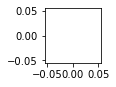

In [1]:
%matplotlib inline
# force plt on windows 10
import matplotlib.pyplot as plt
plt.figure(figsize=(1,1))
plt.plot()

import sys
sys.path.append("..")

import aggets.ds.window as window
import aggets.ds.climate_load as cl
import aggets.ds.window as window

In [2]:
data = cl.load()

In [3]:
CONV_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)

conv_window = window.WindowGenerator(
    train_df = data['train'],
    val_df = data['val'],
    test_df = data['test'],
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)']
)
conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

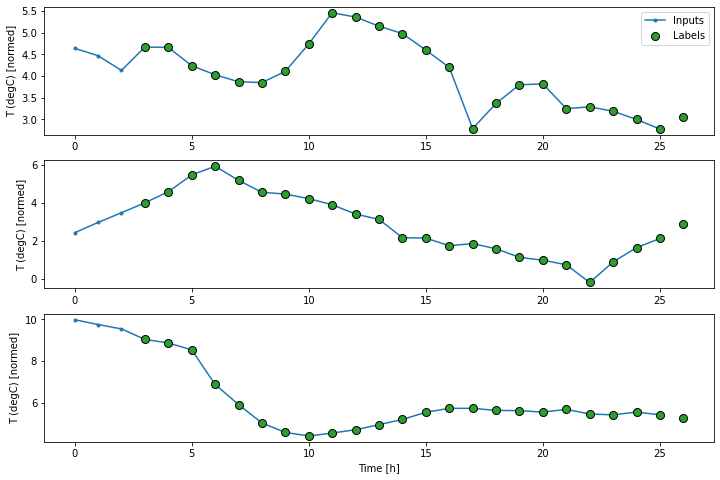

In [4]:
conv_window.plot()

In [5]:
print('X(batch, sequence, features) =', next(conv_window.train)[0].shape)
print('y(batch, sequence, features) =', next(conv_window.train)[1].shape)

X(batch, sequence, features) = torch.Size([32, 26, 19])
y(batch, sequence, features) = torch.Size([32, 24, 1])


/home/rwiatr/anaconda3/envs/env-phd/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370117127/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


epoch 0 batch 1000 loss=1.36, MTL=26.4, MVL=nan				
epoch 1 batch 2000 loss=1.29, MTL=1.11, MVL=1.13				
epoch 1 batch 3000 loss=0.815, MTL=0.961, MVL=1.13				
epoch 2 batch 4000 loss=0.733, MTL=0.814, MVL=0.725				
epoch 3 batch 5000 loss=0.908, MTL=0.766, MVL=0.769				
epoch 3 batch 6000 loss=0.653, MTL=0.756, MVL=0.769				
epoch 4 batch 7000 loss=0.759, MTL=0.726, MVL=0.852				
epoch 5 batch 8000 loss=0.76, MTL=0.703, MVL=0.731				
epoch 5 batch 9000 loss=0.712, MTL=0.681, MVL=0.731				
epoch 6 batch 10000 loss=0.692, MTL=0.644, MVL=0.731				
epoch 7 batch 11000 loss=0.551, MTL=0.629, MVL=0.521				
epoch 7 batch 12000 loss=0.469, MTL=0.625, MVL=0.521				
epoch 8 batch 13000 loss=0.646, MTL=0.599, MVL=0.597				
epoch 9 batch 14000 loss=0.722, MTL=0.579, MVL=0.532				
epoch 9 batch 15000 loss=0.536, MTL=0.574, MVL=0.532				


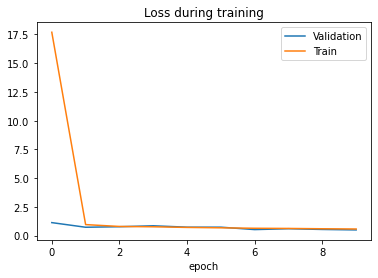

In [6]:
import aggets.train as train
import aggets.model.simple as simple

model = simple.conv_1d(CONV_WIDTH, 19, 64)
train.train_window_model(model, conv_window, max_epochs=10)

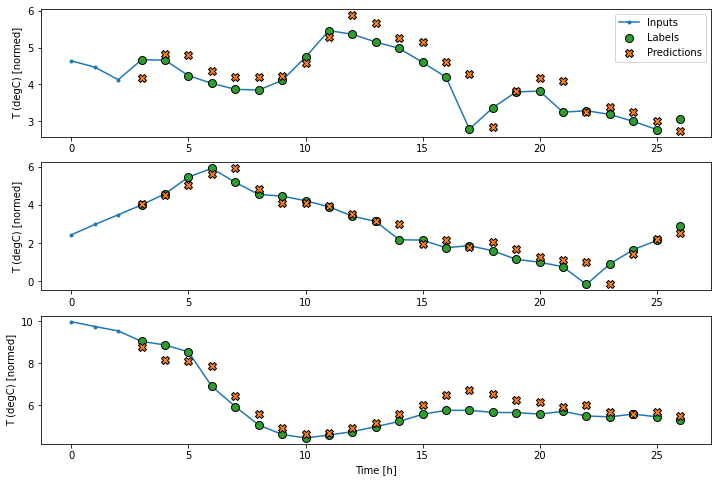

In [7]:
conv_window.plot(model)

In [61]:
CONV_WIDTH = 5
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)

single_step_window = window.WindowGenerator(
    train_df = data['train'],
    val_df = data['val'],
    test_df = data['test'],
    input_width=1, label_width=1, shift=1)

wide_window = window.WindowGenerator(
    train_df = data['train'],
    val_df = data['val'],
    test_df = data['test'],
    input_width=LABEL_WIDTH, label_width=LABEL_WIDTH, shift=1)

conv_wide_window = window.WindowGenerator(
    train_df = data['train'],
    val_df = data['val'],
    test_df = data['test'],
    input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1)

for example_inputs, example_labels in [next(wide_window.train)]:
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): torch.Size([32, 24, 19])
Labels shape (batch, time, features): torch.Size([32, 24, 19])


epoch 0 batch 1000 loss=57.1, MTL=1.05e+04, MVL=nan				
epoch 1 batch 2000 loss=69.7, MTL=75.5, MVL=65.0				
epoch 1 batch 3000 loss=57.3, MTL=72.4, MVL=65.0				
epoch 2 batch 4000 loss=28.8, MTL=48.1, MVL=52.3				
epoch 3 batch 5000 loss=20.9, MTL=19.1, MVL=17.8				
epoch 3 batch 6000 loss=17.1, MTL=18.3, MVL=17.8				
epoch 4 batch 7000 loss=16.8, MTL=17.3, MVL=16.4				
epoch 5 batch 8000 loss=13.9, MTL=16.4, MVL=15.2				
epoch 5 batch 9000 loss=17.6, MTL=16.3, MVL=15.2				
epoch 6 batch 10000 loss=19.6, MTL=15.8, MVL=14.7				
epoch 7 batch 11000 loss=16.4, MTL=15.4, MVL=15.0				
epoch 7 batch 12000 loss=17.1, MTL=15.4, MVL=15.0				
epoch 8 batch 13000 loss=14.3, MTL=15.2, MVL=14.1				
epoch 9 batch 14000 loss=15.2, MTL=15.3, MVL=14.3				
epoch 9 batch 15000 loss=17.5, MTL=15.1, MVL=14.3				


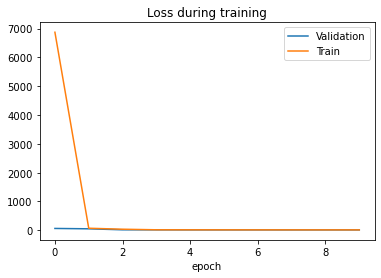

In [62]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


class FitLoop:
    def __init__(self, stop, criterion, net, optimizer, log_every=100, path=None):
        self.stop = stop
        self.criterion = criterion
        self.net = net
        self.optimizer = optimizer
        self.log_every = log_every
        self.path = path

    def fit(self, train_loader, validation_loader=None, load_best=True):
        if validation_loader is None:
            validation_loader = train_loader

        batch_num = 0
        val_losses = None
        while not self.stop.is_stop():
            train_losses = []

            for batch_id, (X, y) in enumerate(train_loader()):
                yhat = self.net(X)
                self.optimizer.zero_grad()
                
                loss = self.criterion(yhat, y)

                loss.backward()
                self.optimizer.step()

                train_losses.append(loss.item())

                if ((batch_num + 1) % self.log_every) == 0:
                    print('epoch {} batch {} loss={:.3}, '
                          'MTL={:.3}, '
                          'MVL={:.3}'
                          '\t\t\t\t\r'
                          .format(self.stop.epoch,
                                  batch_num + 1,
                                  loss.item(),
                                  np.mean(np.abs(train_losses)),
                                  np.mean(np.abs(val_losses)) if val_losses is not None else np.nan))
                batch_num += 1

            val_losses = []
            self.net.eval()
            with torch.no_grad():
                for batch_id, (X, y) in enumerate(validation_loader()):
                    outputs = self.net(X)
                    loss = self.criterion(outputs, y)
                    val_losses.append(loss.item())

            self.net.train()
            self.stop.update_epoch_loss(validation_loss=np.mean(np.abs(val_losses)),
                                        train_loss=np.mean(np.abs(train_losses)))

            if self.stop.is_best() and self.path is not None:
                torch.save(self.net.state_dict(), self.path)
        if self.path is not None and load_best:
            self.load_best_state()

    def load_best_state(self):
        self.net.load_state_dict(torch.load(self.path))
        self.net.eval()


class EarlyStop:

    def __init__(self, patience=100, max_epochs=None):
        self.patience = patience
        self.best_loss = np.inf
        self.failures = 0
        self.epoch = 0
        self.train_losses = []
        self.val_losses = []
        self.max_epochs = max_epochs if max_epochs is not None else np.inf
        self.is_best_loss = False

    def update_epoch_loss(self, train_loss, validation_loss):
        self.train_losses.append(train_loss)
        self.val_losses.append(validation_loss)
        self.epoch += 1

        if validation_loss >= self.best_loss:
            self.failures += 1
            self.is_best_loss = False
        else:
            self.failures = 0
            self.best_loss = validation_loss
            self.is_best_loss = True

    def is_best(self):
        return self.is_best_loss

    def is_stop(self):
        return (self.failures > self.patience) or (self.epoch >= self.max_epochs)

    def plot_loss(self, plot_train_loss=False, moving_avg=100):
        if moving_avg:
            mvn_avg = len(self.val_losses) // moving_avg
            plt.plot(pd.Series(self.val_losses).rolling(max(mvn_avg, 1), center=True).mean(), label='Validation')
        else:
            plt.plot(self.val_losses, label='Validation')
        if plot_train_loss:
            if moving_avg:
                mvn_avg = len(self.val_losses) // moving_avg
                plt.plot(pd.Series(self.train_losses).rolling(max(mvn_avg, 1), center=True).mean(), label='Train')
            else:
                plt.plot(self.train_losses, label='Train')
        plt.title('Loss during training')
        plt.xlabel('epoch')
        plt.legend()


def train_window_model(model, window, lr=0.001, criterion=nn.MSELoss(), plot_loss=True,
                       max_epochs=100, patience=1000, log_every=1000):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    stop = EarlyStop(patience=patience, max_epochs=max_epochs)
    loop = FitLoop(
        stop=stop,
        net=model,
        criterion=criterion,
        optimizer=optimizer,
        log_every=log_every,
        path='model.bin'
    )

    loop.fit(lambda: window.train, lambda: window.val, load_best=False)
    if plot_loss:
        stop.plot_loss(plot_train_loss=True)


def train_model(model, data, lr=0.001, criterion=nn.MSELoss(), plot_loss=True,
                max_epochs=100, patience=1000, log_every=1000):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    stop = EarlyStop(patience=patience, max_epochs=max_epochs)
    loop = FitLoop(
        stop=stop,
        net=model,
        criterion=criterion,
        optimizer=optimizer,
        log_every=log_every,
        path='model.bin'
    )

    loop.fit(lambda: data.train, lambda: data.val, load_best=False)
    if plot_loss:
        stop.plot_loss(plot_train_loss=True)


conv = simple.conv_1d(conv_width=CONV_WIDTH, features=19, hidden=8, out_features=19)
train_window_model(conv, conv_wide_window, max_epochs=10, criterion=nn.MSELoss(reduction='mean'), patience=10)

In [49]:
x = torch.randn(32, 24, 19)
yhat = torch.sigmoid(x)
y = torch.randint(2, (32, 24, 19), dtype=torch.float)
loss = nn.MSELoss(reduction='mean')(yhat, y)
loss

tensor(0.2901)

epoch 0 batch 1000 loss=1.24e+05, MTL=1.29e+05, MVL=nan				
epoch 1 batch 2000 loss=1.15e+05, MTL=1.17e+05, MVL=1.2e+05				
epoch 1 batch 3000 loss=1.09e+05, MTL=1.13e+05, MVL=1.2e+05				
epoch 2 batch 4000 loss=9.95e+04, MTL=1.03e+05, MVL=1.07e+05				
epoch 3 batch 5000 loss=9.14e+04, MTL=9.29e+04, MVL=9.45e+04				
epoch 3 batch 6000 loss=8.43e+04, MTL=8.93e+04, MVL=9.45e+04				
epoch 4 batch 7000 loss=7.77e+04, MTL=8.04e+04, MVL=8.35e+04				
epoch 5 batch 8000 loss=7.15e+04, MTL=7.22e+04, MVL=7.33e+04				
epoch 5 batch 9000 loss=6.5e+04, MTL=6.91e+04, MVL=7.33e+04				
epoch 6 batch 10000 loss=5.9e+04, MTL=6.16e+04, MVL=6.4e+04				
epoch 7 batch 11000 loss=5.42e+04, MTL=5.47e+04, MVL=5.54e+04				
epoch 7 batch 12000 loss=4.84e+04, MTL=5.21e+04, MVL=5.54e+04				
epoch 8 batch 13000 loss=4.43e+04, MTL=4.57e+04, MVL=4.75e+04				
epoch 9 batch 14000 loss=3.97e+04, MTL=3.98e+04, MVL=4.03e+04				
epoch 9 batch 15000 loss=3.52e+04, MTL=3.76e+04, MVL=4.03e+04				
epoch 10 batch 16000 loss=3.1

epoch 81 batch 125000 loss=1.26e+02, MTL=1.56e+02, MVL=1.35e+02				
epoch 82 batch 126000 loss=1.37e+02, MTL=1.56e+02, MVL=1.34e+02				
epoch 82 batch 127000 loss=1.45e+02, MTL=1.56e+02, MVL=1.34e+02				
epoch 83 batch 128000 loss=1.52e+02, MTL=1.56e+02, MVL=1.34e+02				
epoch 84 batch 129000 loss=1.87e+02, MTL=1.55e+02, MVL=1.34e+02				
epoch 84 batch 130000 loss=1.59e+02, MTL=1.55e+02, MVL=1.34e+02				
epoch 85 batch 131000 loss=1.55e+02, MTL=1.55e+02, MVL=1.33e+02				
epoch 86 batch 132000 loss=1.31e+02, MTL=1.55e+02, MVL=1.33e+02				
epoch 86 batch 133000 loss=1.44e+02, MTL=1.54e+02, MVL=1.33e+02				
epoch 87 batch 134000 loss=1.96e+02, MTL=1.54e+02, MVL=1.33e+02				
epoch 88 batch 135000 loss=1.65e+02, MTL=1.52e+02, MVL=1.32e+02				
epoch 88 batch 136000 loss=1.45e+02, MTL=1.54e+02, MVL=1.32e+02				
epoch 89 batch 137000 loss=1.47e+02, MTL=1.54e+02, MVL=1.32e+02				
epoch 90 batch 138000 loss=1.6e+02, MTL=1.53e+02, MVL=1.31e+02				
epoch 90 batch 139000 loss=1.43e+02, MTL=1.54e+02

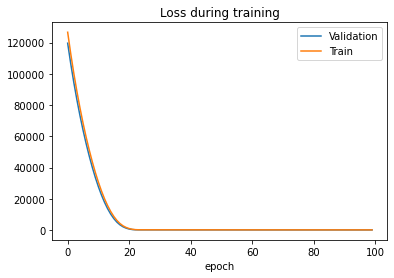

In [65]:
lstm_model = simple.lstm(features=19, out_features=19, hidden=8)
train_window_model(lstm_model, wide_window, max_epochs=100, criterion=nn.MSELoss(reduction='mean'), 
                   patience=10, lr=0.01)